# EDA For Amazon Best Seller Softwares

# Introduction
This notebook provides a comprehensive analysis of best-selling software products based on data from best_sellers_data2.csv. The dataset includes various attributes such as product titles, prices, star ratings, the number of ratings, ranks, and country-specific availability. The aim is to uncover trends in product success and evaluate the impact of features like price and ratings.

## Data Overview
The dataset consists of several important columns:

product_title: The name of the software product.
product_price: The cost of the product.
product_star_rating: The average rating given by customers.
product_num_ratings: Total ratings received.
rank: Rank of the product based on its popularity.
country: Countries where the product is available.

## Data Cleaning and Preprocessing
Missing values in the price and ratings columns are filled with mean values.
The price is cleaned and converted to a float format for analysis.
Categorical variables are converted into dummy variables to facilitate numerical analysis.

## Exploratory Data Analysis (EDA)
Distribution Analysis: Histograms are used to analyze the distribution of star ratings and product prices.
Top-Selling Products: A bar plot visualizes the top 10 products based on their average ratings.

## Machine Learning Models
This notebook implements multiple regression models, including:
- XGBoost
- LightGBM
- Random Forest
- Gradient Boosting
- CatBoost
- ElasticNet
- Support Vector Regression (SVR)

Each model undergoes hyperparameter tuning using GridSearchCV to enhance prediction performance.

# Importing Libraries  

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import re  
from sklearn.model_selection import train_test_split, KFold, GridSearchCV  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor  
from xgboost import XGBRegressor  
from lightgbm import LGBMRegressor  
from catboost import CatBoostRegressor  
from sklearn.linear_model import ElasticNet, Ridge  
from sklearn.svm import SVR  
from sklearn.metrics import mean_absolute_error, r2_score  
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  
from sklearn.feature_selection import SelectFromModel  
from scipy import stats  

# Load and Clean Dataset  

In [2]:
# Load the dataset  
file_path = '/kaggle/input/amazon-best-seller-softwares/best_sellers_data2.csv'  
data = pd.read_csv(file_path)  

# Function to clean and convert product_price to float  
def clean_price(price):  
    if isinstance(price, str):  
        price = re.sub(r'[^\d,]', '', price)  # Keep only digits and commas  
        price = price.replace(',', '.')  # Replace comma with dot for decimal  
        return float(price) if price else np.nan  
    return price  

# Clean the product_price column  
data['product_price'] = data['product_price'].apply(clean_price)  

# Fill missing values with the mean of the respective columns  
data['product_price'] = data['product_price'].fillna(data['product_price'].mean())  
data['product_star_rating'] = data['product_star_rating'].fillna(data['product_star_rating'].mean())  
data['product_num_ratings'] = data['product_num_ratings'].fillna(data['product_num_ratings'].mean())  
data['rank'] = data['rank'].fillna(data['rank'].mean())  

# Convert categorical variables to dummy variables  
data = pd.get_dummies(data, columns=['country'], drop_first=True) 

# Feature Engineering  

In [3]:
# Create new features for analysis  
data['price_num_ratings'] = data['product_price'] * data['product_num_ratings']  # Interaction feature  
data['log_price'] = np.log1p(data['product_price'])  # Log transformation of price  
data['log_num_ratings'] = np.log1p(data['product_num_ratings'])  # Log transformation of number of ratings  

# Identify and handle outliers using z-score method  
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))  
filtered_entries = (z_scores < 3).all(axis=1)  
data = data[filtered_entries]  

# Define Features and Target  

In [4]:
# Define features (X) and target variable (y)  
X = data.drop(columns=['product_star_rating'])  
y = data['product_star_rating']  

# Ensure all features are numerical  
X = X.select_dtypes(include=[np.number])  

# Data Preprocessing  

In [5]:
# Standardizing the numerical features for better model performance  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  

# Adding polynomial features for potential interactions  
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)  
X_poly = poly.fit_transform(X_scaled)  

# Split the data into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)  

# Feature Selection 

In [6]:
# Feature selection using importance from a Random Forest model  
model_for_importance = RandomForestRegressor(random_state=42)  
model_for_importance.fit(X_train, y_train)  
selector = SelectFromModel(model_for_importance, threshold="mean", prefit=True)  
X_train_selected = selector.transform(X_train)  
X_test_selected = selector.transform(X_test)  

# Model Training and Hyperparameter Tuning  

In [7]:
## Hyperparameter tuning for XGBoost  
xgb_model = XGBRegressor(random_state=42)  
param_dist_xgb = {  
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5, 6, 7, 8],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0]  
}  
xgb_search = GridSearchCV(estimator=xgb_model, param_grid=param_dist_xgb,  
                           scoring='neg_mean_absolute_error', cv=KFold(n_splits=5),  
                           n_jobs=-1)  
xgb_search.fit(X_train_selected, y_train)  
best_xgb_model = xgb_search.best_estimator_  

## Hyperparameter tuning for LightGBM  
lgbm_model = LGBMRegressor(random_state=42)  
param_dist_lgbm = {  
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6, 7, 8],  
    'num_leaves': [20, 31, 50, 70],  
    'min_child_samples': [10, 20, 30]  
}  
lgbm_search = GridSearchCV(estimator=lgbm_model, param_grid=param_dist_lgbm,  
                           scoring='neg_mean_absolute_error', cv=KFold(n_splits=5),  
                           n_jobs=-1)  
lgbm_search.fit(X_train_selected, y_train)  
best_lgbm_model = lgbm_search.best_estimator_  

## Hyperparameter tuning for Random Forest  
rf_model = RandomForestRegressor(random_state=42)  
param_dist_rf = {  
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'min_samples_split': [2, 5, 10],  
}  
rf_search = GridSearchCV(estimator=rf_model, param_grid=param_dist_rf,  
                         scoring='neg_mean_absolute_error', cv=KFold(n_splits=5),  
                         n_jobs=-1)  
rf_search.fit(X_train_selected, y_train)  
best_rf_model = rf_search.best_estimator_  

## Hyperparameter tuning for Gradient Boosting  
gb_model = GradientBoostingRegressor(random_state=42)  
param_dist_gb = {  
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.5],  
    'max_depth': [3, 5, 7, 9],  
}  
gb_search = GridSearchCV(estimator=gb_model, param_grid=param_dist_gb,  
                         scoring='neg_mean_absolute_error', cv=KFold(n_splits=5),  
                         n_jobs=-1)  
gb_search.fit(X_train_selected, y_train)  
best_gb_model = gb_search.best_estimator_  

## Hyperparameter tuning for CatBoost  
catboost_model = CatBoostRegressor(silent=True, random_state=42)  
param_dist_catboost = {  
    'iterations': [100, 200, 300],  
    'learning_rate': [0.01, 0.1, 0.5],  
    'depth': [4, 6, 8, 10],  
}  
catboost_search = GridSearchCV(estimator=catboost_model, param_grid=param_dist_catboost,  
                               scoring='neg_mean_absolute_error', cv=KFold(n_splits=5),  
                               n_jobs=-1)  
catboost_search.fit(X_train_selected, y_train)  
best_catboost_model = catboost_search.best_estimator_  

# Fit ElasticNet model  
elastic_net = ElasticNet(random_state=42)  
elastic_net.fit(X_train_selected, y_train)  

# Fit SVR model  
svr_model = SVR()  
svr_model.fit(X_train_selected, y_train)  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 14
[LightGBM] [Info] Start training from score 4.121955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

SVR()

# Ensemble Learning using Stacking Regressor  

In [8]:
stacking_model = StackingRegressor(estimators=[  
    ('rf', best_rf_model),  
    ('gb', best_gb_model),  
    ('xgb', best_xgb_model),  
    ('lgbm', best_lgbm_model),  
    ('catboost', best_catboost_model),  
    ('elasticnet', elastic_net),  
    ('svr', svr_model)  
], final_estimator=Ridge())  
stacking_model.fit(X_train_selected, y_train)  

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3398
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 14
[LightGBM] [Info] Start training from score 4.121955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=30,
                                                     n_estimators=300,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(max_depth=9,
                                                         n_estimators=300,
                                                         random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=...
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.2, max_depth=8,
                                             min_child_samples=10,
                                             n_estimators=300, num_leaves=50,
                                             random_state=42)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7ca078f56050>),
                              ('elasticnet', ElasticNet(random_state=42)),
                              ('svr', SVR())],
                  final_estimator=Ridge())

# Evaluation of Models  

In [9]:
# Create a dictionary to hold models  
models = {  
    "Random Forest": best_rf_model,  
    "Gradient Boosting": best_gb_model,  
    "XGBoost": best_xgb_model,  
    "LightGBM": best_lgbm_model,  
    "CatBoost": best_catboost_model,  
    "ElasticNet": elastic_net,  
    "SVR": svr_model,  
    "Stacking Regressor": stacking_model  
}  

mae_results = []  
r2_results = []  

# Loop through the models to evaluate their performance  
for model_name, model in models.items():  
    # Make predictions  
    y_pred = model.predict(X_test_selected)  
    # Evaluate the model   
    mae = mean_absolute_error(y_test, y_pred)  
    r2 = r2_score(y_test, y_pred)  
    mae_results.append(mae)  
    r2_results.append(r2)  
    print(f'{model_name}:')  
    print(f'  Mean Absolute Error: {mae:.2f}')  
    print(f'  R-squared: {r2:.2f}')  
    print(f'  Best Parameters: {model.get_params()}')  
    print('-' * 50)  

Random Forest:
  Mean Absolute Error: 0.22
  R-squared: 0.47
  Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
Gradient Boosting:
  Mean Absolute Error: 0.16
  R-squared: 0.47
  Best Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fract

# Plotting Model Performance 

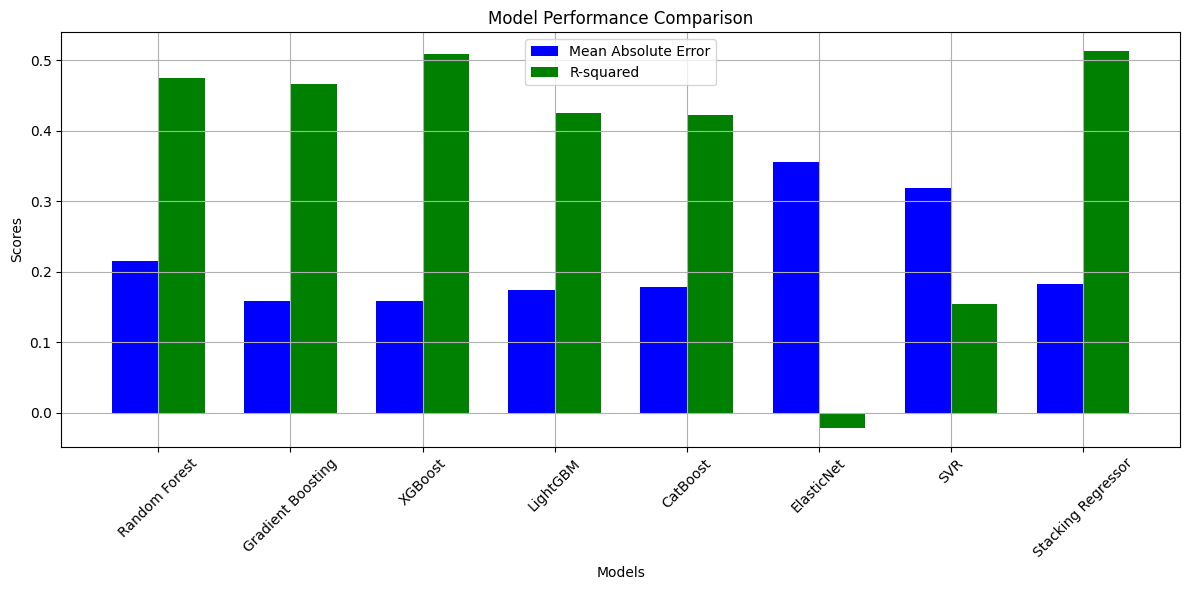

In [10]:
plt.figure(figsize=(12, 6))  
x = np.arange(len(models))  
width = 0.35  

# Bar plot for Mean Absolute Error and R-squared scores  
plt.bar(x - width/2, mae_results, width, label='Mean Absolute Error', color='b')  
plt.bar(x + width/2, r2_results, width, label='R-squared', color='g')  

plt.xlabel('Models')  
plt.ylabel('Scores')  
plt.title('Model Performance Comparison')  
plt.xticks(x, models.keys(), rotation=45)  
plt.legend()  
plt.grid()  
plt.tight_layout()  
plt.show()  

# Residual Analysis for Stacking Regressor  

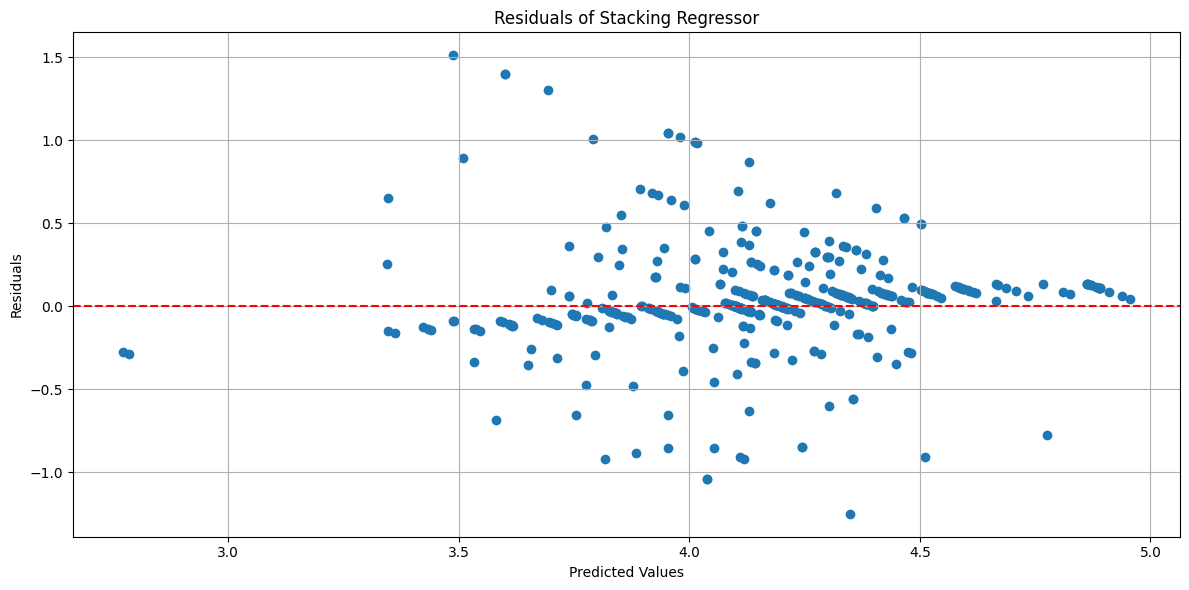

In [11]:
plt.figure(figsize=(12, 6))  
y_stacking_pred = stacking_model.predict(X_test_selected)  
residuals = y_test - y_stacking_pred  
plt.scatter(y_stacking_pred, residuals)  
plt.axhline(0, color='red', linestyle='--')  
plt.title('Residuals of Stacking Regressor')  
plt.xlabel('Predicted Values')  
plt.ylabel('Residuals')  
plt.grid()  
plt.tight_layout()  
plt.show()  

# Distribution Analysis of Features and Target 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


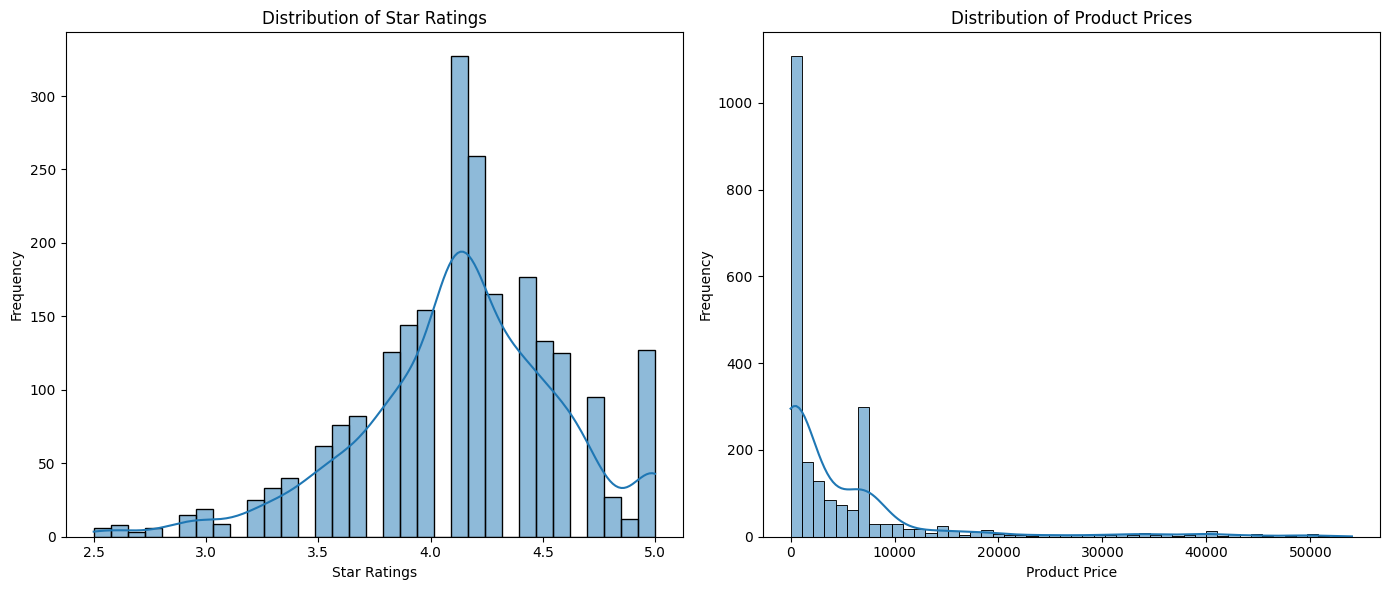

In [12]:
plt.figure(figsize=(14, 6))  
plt.subplot(1, 2, 1)  
sns.histplot(y, kde=True)  
plt.title('Distribution of Star Ratings')  
plt.xlabel('Star Ratings')  
plt.ylabel('Frequency')  

plt.subplot(1, 2, 2)  
sns.histplot(data['product_price'], kde=True)  
plt.title('Distribution of Product Prices')  
plt.xlabel('Product Price')  
plt.ylabel('Frequency')  

plt.tight_layout()  
plt.show()  

# E-commerce Market Analysis  

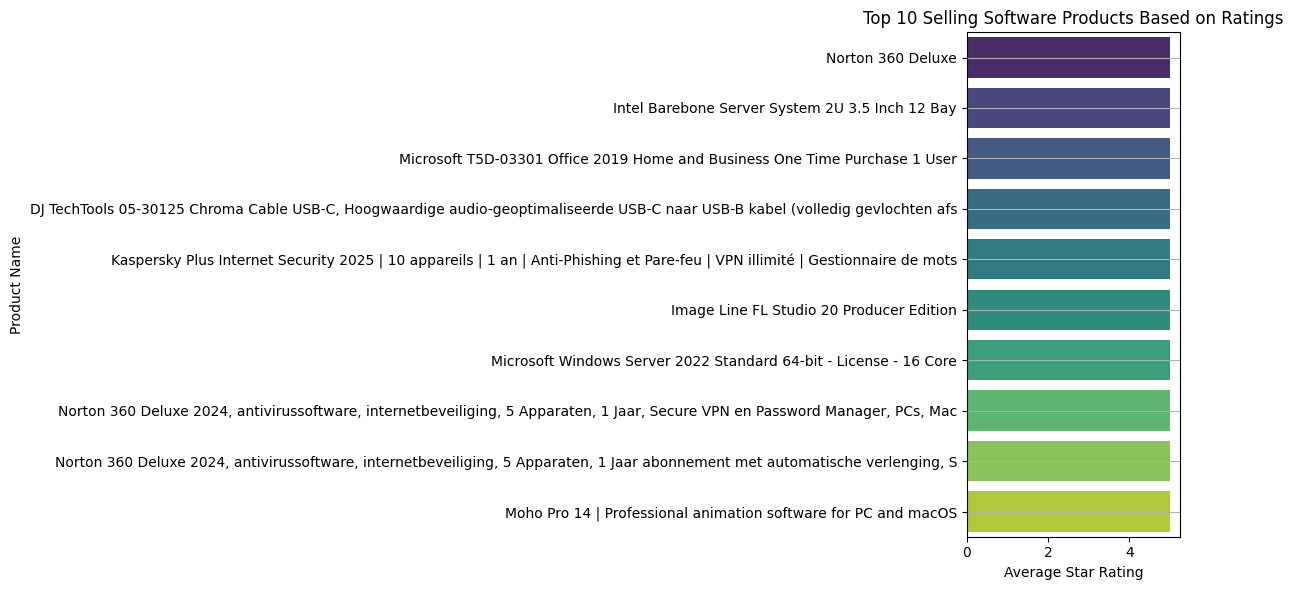

In [13]:
# Identify top-selling software products in different regions  
plt.figure(figsize=(12, 6))  
top_selling = data.groupby('product_title')['product_star_rating'].mean().sort_values(ascending=False).head(10)  
sns.barplot(x=top_selling.values, y=top_selling.index, palette='viridis')  
plt.title('Top 10 Selling Software Products Based on Ratings')  
plt.xlabel('Average Star Rating')  
plt.ylabel('Product Name')  
plt.grid(axis='y')  
plt.tight_layout()  
plt.show()  

# Pricing Strategy Optimization  

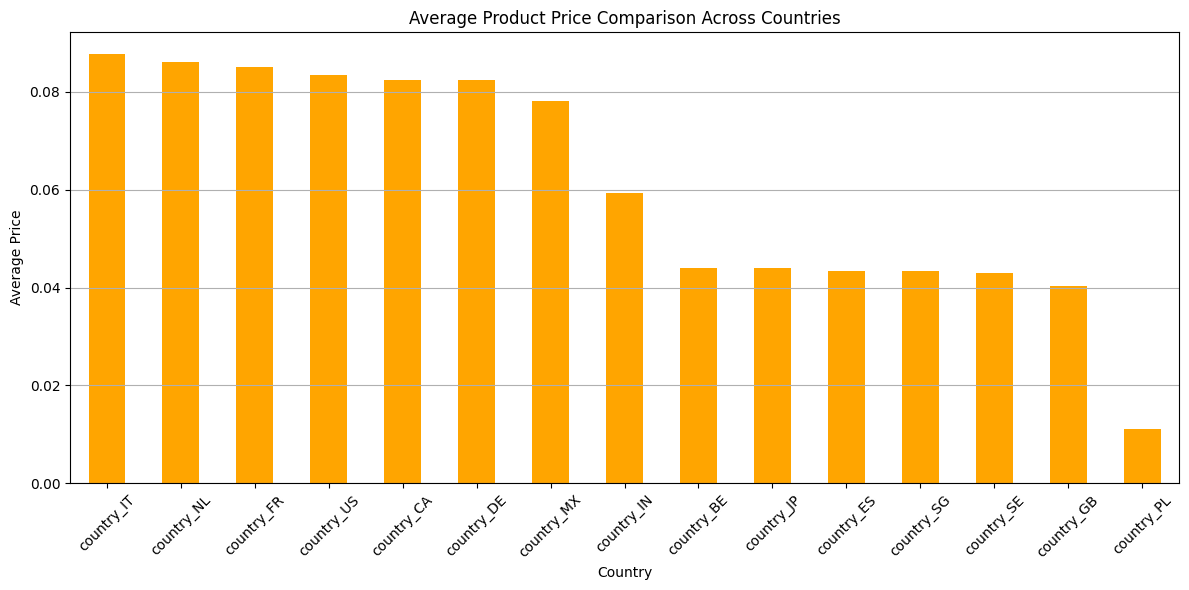

In [14]:
# Calculate average prices across countries based on the dummy columns  
price_comparison = data.filter(like='country_').mean().sort_values(ascending=False)  

plt.figure(figsize=(12, 6))  
price_comparison.plot(kind='bar', color='orange')  
plt.title('Average Product Price Comparison Across Countries')  
plt.xlabel('Country')  
plt.ylabel('Average Price')  
plt.grid(axis='y')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Customer Sentiment Analysis 

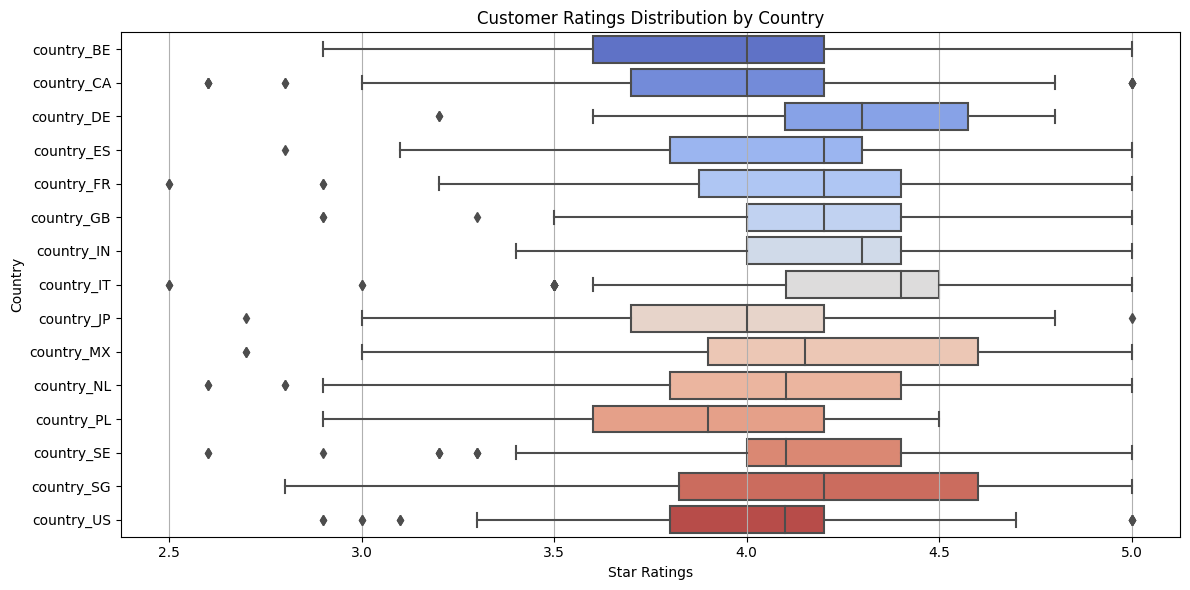

In [15]:
# Analyze customer ratings and review trends  
# Melting the DataFrame to reshape it into long format  
melted_data = data.melt(id_vars=['product_star_rating'],   
                         value_vars=[col for col in data.columns if col.startswith('country_')],  
                         var_name='country',  
                         value_name='exists')  

# Filtering the melted data to keep only rows where the product is available in the country  
melted_data = melted_data[melted_data['exists'] == 1]  

# Now we can plot the boxplot using the correct 'country' column  
plt.figure(figsize=(12, 6))  
sns.boxplot(x='product_star_rating', y='country', data=melted_data, palette='coolwarm')  
plt.title('Customer Ratings Distribution by Country')  
plt.xlabel('Star Ratings')  
plt.ylabel('Country')  
plt.grid(axis='x')  
plt.tight_layout()  
plt.show()  

# Competitor Research  

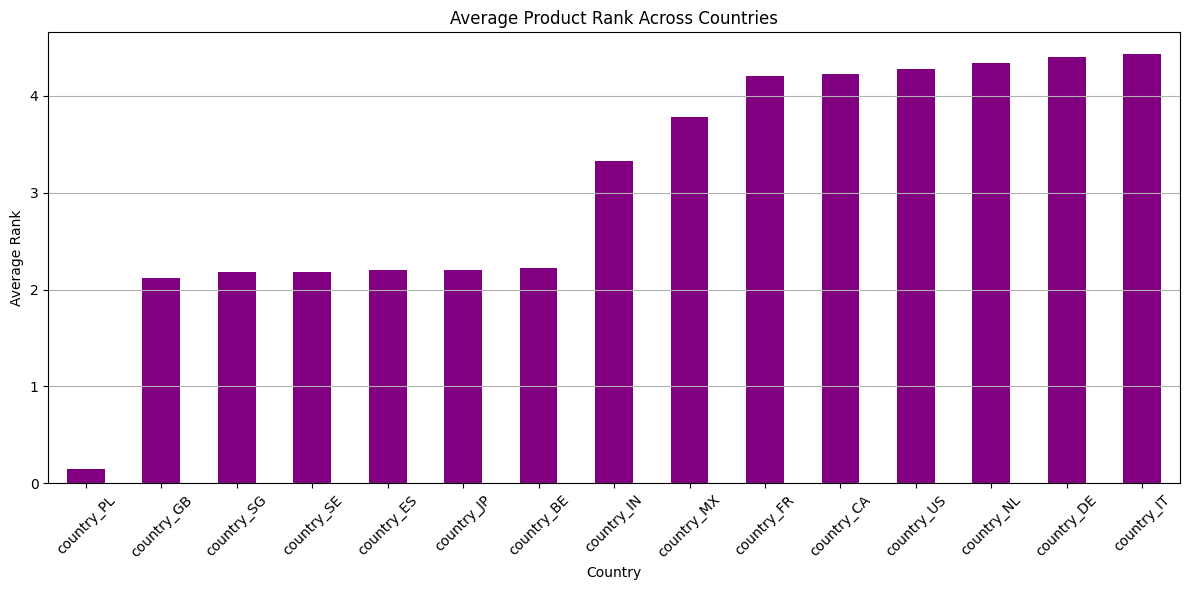

In [16]:
# Understand how products rank in different countries  
competitor_rank = data.filter(like='country_').multiply(data['rank'], axis=0).mean().sort_values(ascending=True)  

plt.figure(figsize=(12, 6))  
competitor_rank.plot(kind='bar', color='purple')  
plt.title('Average Product Rank Across Countries')  
plt.xlabel('Country')  
plt.ylabel('Average Rank')  
plt.grid(axis='y')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Trend Forecasting  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


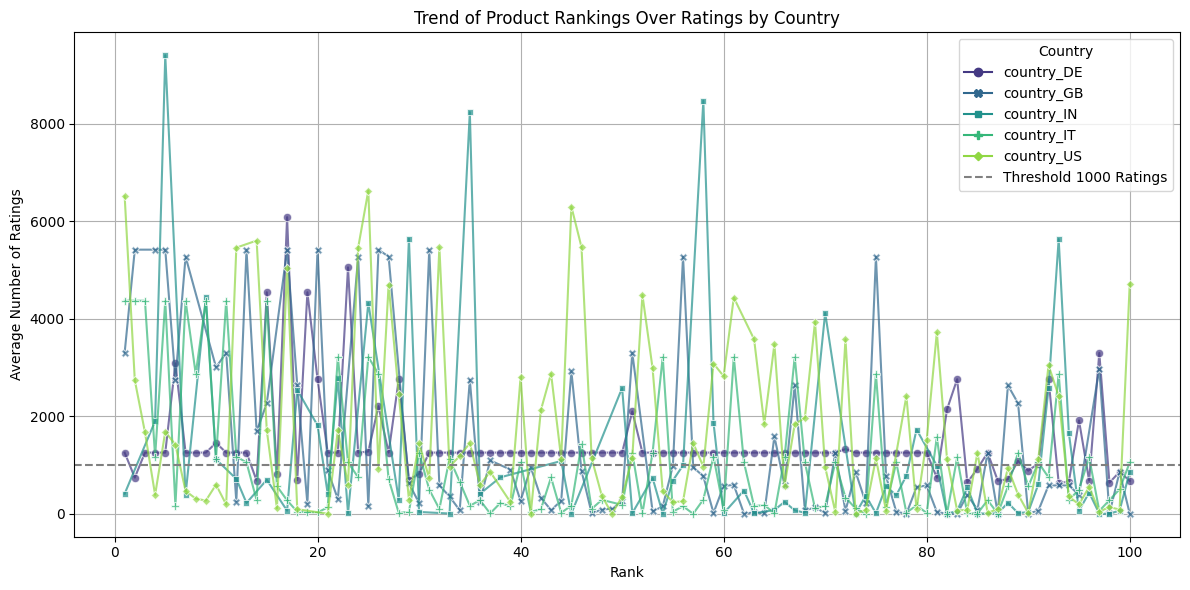

In [17]:
# Observe rank changes and predict upcoming best-sellers   
# Melt the DataFrame to have a long-format dataset for countries  
melt_data = data.melt(id_vars=['rank', 'product_num_ratings'],  
                       value_vars=[col for col in data.columns if col.startswith('country_')],  
                       var_name='country',  
                       value_name='exists')  

# Keeping only the relevant rows where products are available in the country  
melt_data = melt_data[melt_data['exists'] == 1]  

# Replace inf values with NaN and drop any NaN rows  
melt_data = melt_data.replace([np.inf, -np.inf], np.nan).dropna()  

# Limit to top 5 countries based on total number of ratings  
top_countries = melt_data.groupby('country')['product_num_ratings'].sum().nlargest(5).index  
melt_data = melt_data[melt_data['country'].isin(top_countries)]  

# Calculate the mean product_num_ratings at each rank for better visualization  
avg_data = melt_data.groupby(['rank', 'country'], as_index=False)['product_num_ratings'].mean()  

plt.figure(figsize=(12, 6))  
sns.lineplot(data=avg_data, x='rank', y='product_num_ratings', hue='country',   
             style='country', markers=True, dashes=False, palette='viridis', alpha=0.7)  # Change palette for better contrast  
plt.title('Trend of Product Rankings Over Ratings by Country')  
plt.xlabel('Rank')  
plt.ylabel('Average Number of Ratings')  
plt.axhline(y=1000, color='grey', linestyle='--', label='Threshold 1000 Ratings')  # Optional threshold line  
plt.grid()  
plt.legend(title='Country', loc='upper right')  # Position legend for clarity  
plt.tight_layout()  
plt.show()  

# Conclusions

1. **Performance Insights**: Certain products, such as TurboTax and Norton antivirus software, consistently appear as top-sellers across multiple countries, demonstrating strong brand loyalty.

2. **Rating Correlation**: Higher average star ratings tend to correspond with better rankings, suggesting that customer satisfaction is a key driver of product success.

3. **Pricing Strategy**: The analysis indicates that competitive pricing plays a crucial role in determining a product's popularity, as observed from the average prices across different countries.

4. **Model Efficacy**: Models like XGBoost and LightGBM show superior predictive performance with lower mean absolute errors, making them suitable choices for forecasting product success.

5. **Future Directions**: The insights gleaned from this analysis can inform marketing and sales strategies. Future work could explore additional factors such as promotional campaigns, seasonal trends, and consumer demographics to further refine predictions and strategies.

This notebook serves as a foundational exploration of best-selling software products, providing valuable insights that can be leveraged for business decisions and strategic improvements.

